In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 100

## Shifted lognormal model with latent Markov volatility
The model starts with a flat volatility at $\sigma_0$ which can jump once to a different value $\sigma_1$ with intensity $\lambda$. 

The call price in this model is (assuming no interest rate/T-forward measure):

$$
E[(X_T-K)_+] = E[E[BS(\sigma^2T= \sigma_0^2 \tau + \sigma_1^2 (T-\tau) ) 1_{\tau<T} + BS(\sigma^2T= \sigma_0^2 T ) 1_{\tau>=T}| \tau]]
$$

The conditional expectation is valued using the classical Black-Scholes formula with a volatility dependent on $\tau$; then the outer expectation is computed semi-analytically using the fact that $\tau$ follows an exponential distribution of parameter $\lambda$.

Compared to the usual Black-Scholes model, the hidden variable creates a volatility smile.


In [4]:
f = 100

sigma_0 = 20*ONE_PCT
sigma_1 = 40*ONE_PCT

intensity = 1.5

shift = 0.8
mixing = 0.8
L = f

K_lo = 80
K_hi = 120

In [5]:
Model_LN = SLN_Markov_simple_LN(sigma_0=sigma_0,
                                sigma_1=sigma_1,
                                intensity=intensity,
                                f=f,
                                shift=shift,
                                mixing=mixing,
                                L=L,
                                n_strikes=N_STRIKES,
                                K_lo=K_lo,
                                K_hi=K_hi,
                                strike_type='strike',
                               )

Model_N = SLN_Markov_simple_N(sigma_0=sigma_0,
                              sigma_1=sigma_1,
                              intensity=intensity,
                              f=f,
                              shift=shift,
                              mixing=mixing,
                              L=L,
                              n_strikes=N_STRIKES,
                              K_lo=K_lo,
                              K_hi=K_hi,
                              strike_type='strike',
                             )

## Implied volatility smile

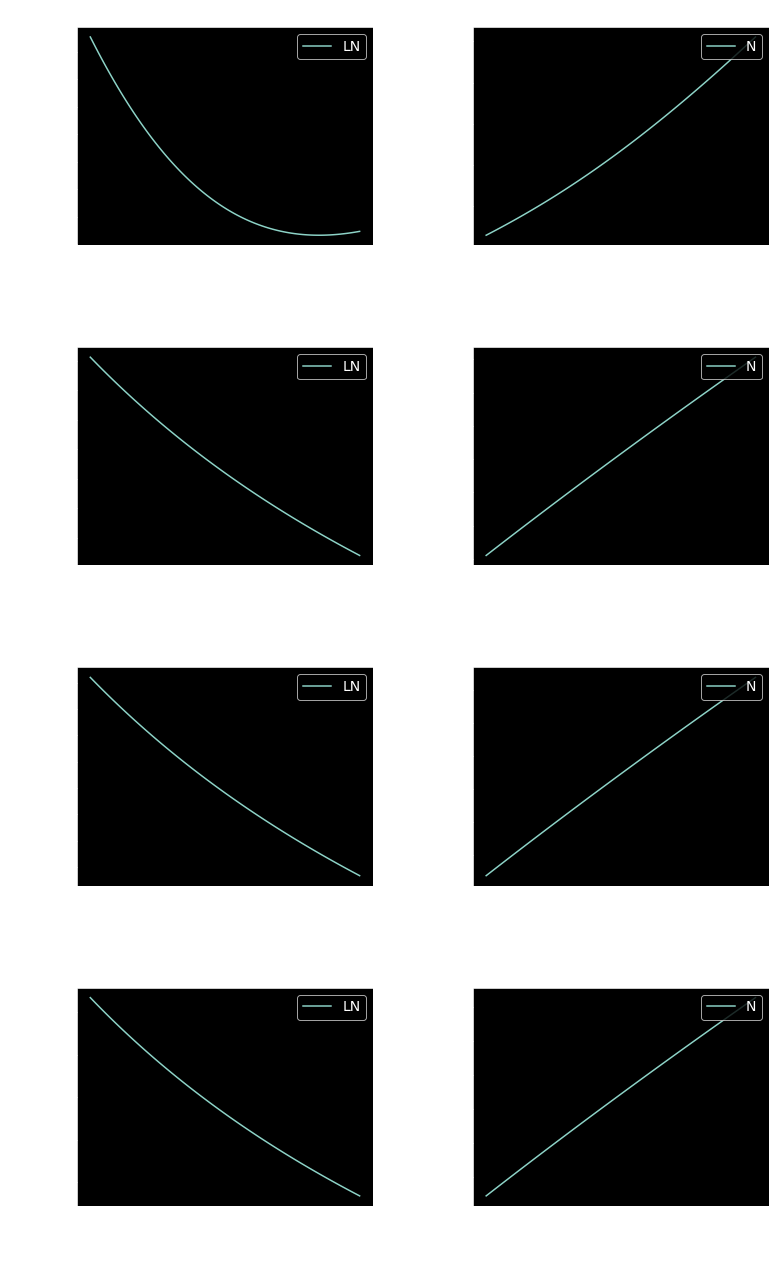

In [6]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'
labels = ['LN', 'N']

T_expiries = [1.0, 5.0, 10.0, 20.0]

fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax_row in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    x_grid = Model_LN.strike_grid

    models = [Model_LN, Model_N]
    for j, ax in enumerate(ax_row):
        model = models[j]
        label = labels[j]
        smile = list(model.smile.values())
        
        ax.plot(x_grid, smile, label=label)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.set_title('expiry={}y'.format(T_expiry))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    
plt.tight_layout()
plt.show()

## Backbone i.e ATM vol move implied by forward move

Flat backbone : the model does not have any smile dynamics

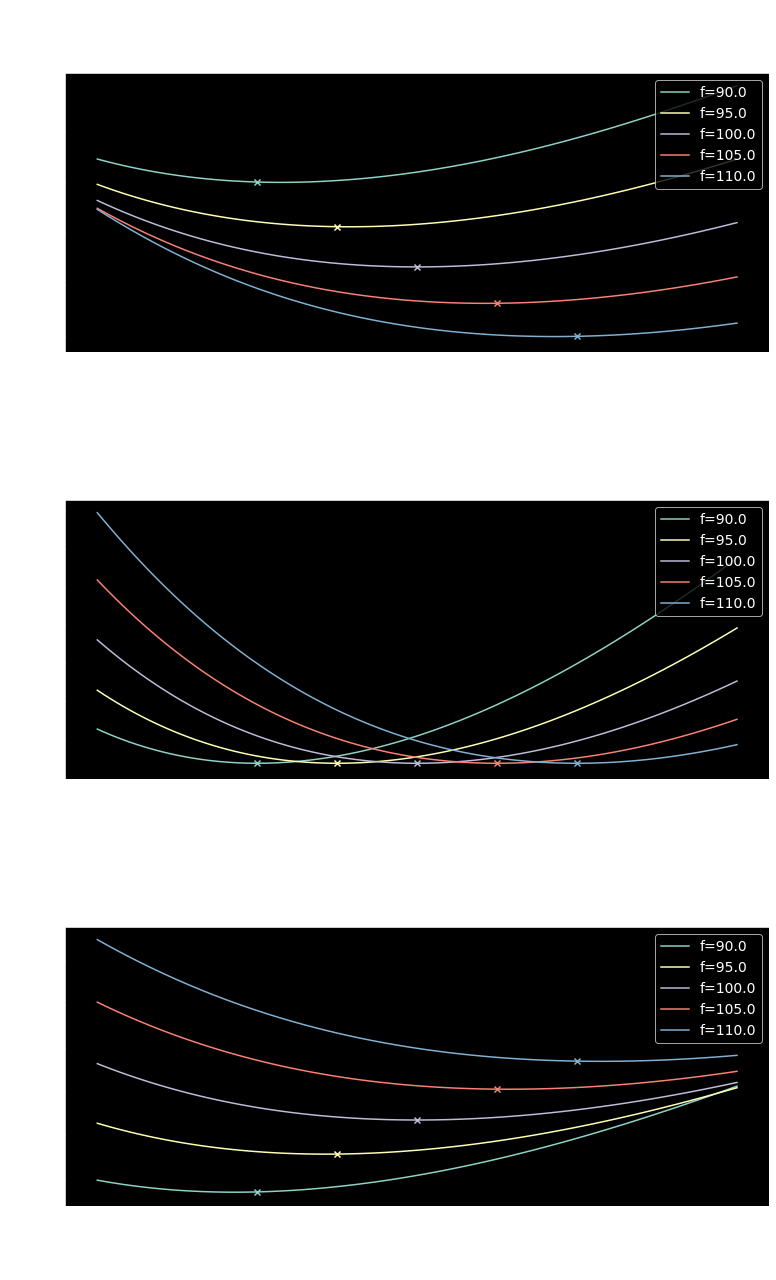

In [7]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 100.0

sigma_0 = 20*ONE_PCT
sigma_1 = 40*ONE_PCT
intensity = 0.5

shift = 1.0
mixing = 0.9
L = f

mixings = [
    0.7,
    1.0,
    1.3,
]

f_shocks = [
    -10.0, 
    -5.0, 
    0.0, 
    5, 
    10,
]

Model_LN = SLN_Markov_simple_LN(sigma_0=sigma_0,
                                sigma_1=sigma_1,
                                intensity=intensity,
                                shift=shift,
                                mixing=mixing,
                                L=L,
                                f=f,
                                n_strikes=N_STRIKES,
                                K_lo=K_lo,
                                K_hi=K_hi,
                                strike_type='strike',
                               )

fig, axes = plt.subplots(nrows=3, ncols=1)
    
for i, ax in enumerate(axes):
    mixing = mixings[i]
    Model_LN.mixing = mixing
    for f_shock in f_shocks:
        Model_LN.f = f+f_shock
        smile = list(Model_LN.smile.values())
        label = 'f={}'.format(f+f_shock)
        ax.plot(Model_LN.strike_grid, smile, label=label)
        ax.scatter([Model_LN.f], [Model_LN.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
        ax.set_title('{}\n'.format(Model_LN.vol_type)\
                     +r'$mixing$={}'.format(Model_LN.mixing)+'\n'\
                    )

plt.tight_layout()
plt.show()

## Parameter sensitivities

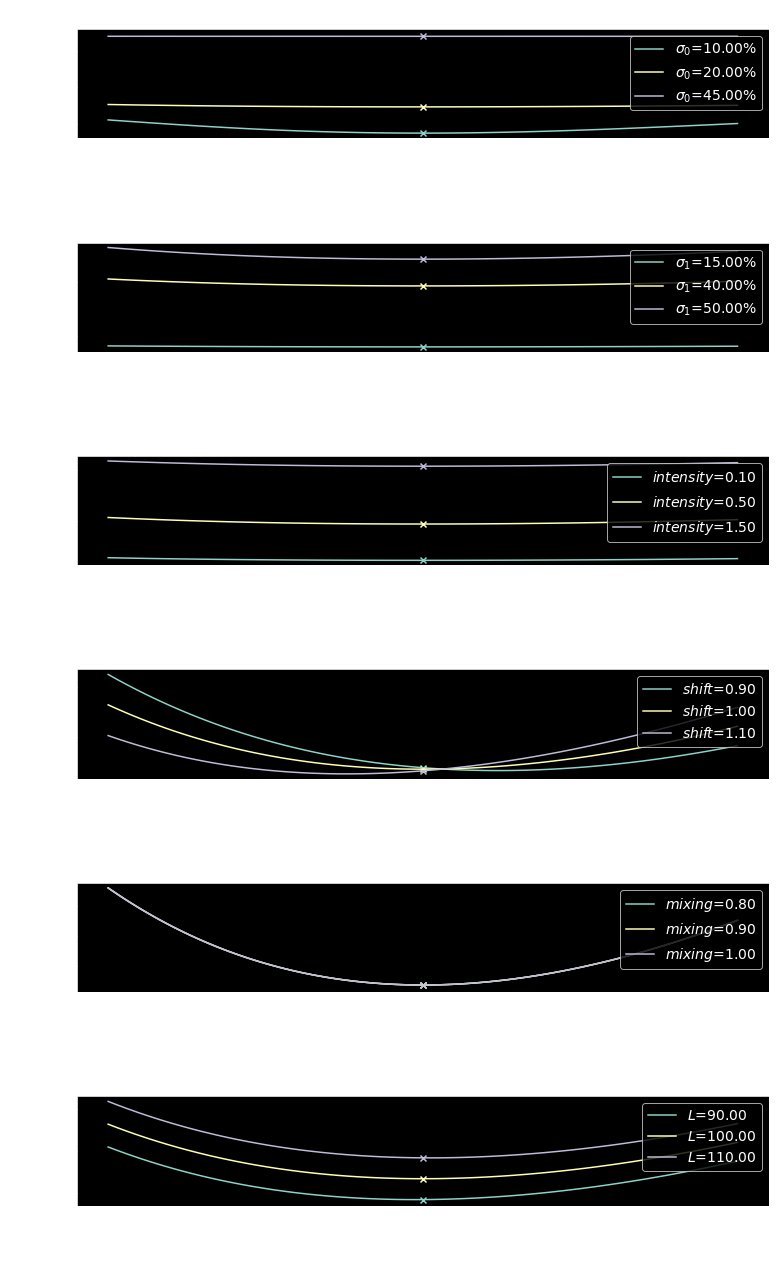

In [8]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 100.0

sigma_0 = 20*ONE_PCT
sigma_1 = 40*ONE_PCT
intensity = 0.5
shift = 1.0
mixing = 0.9
L = f

sigma_0_shocks = [-0.1, 0.0, 0.25]
sigma_1_shocks = [-0.25, 0.0, 0.1]
intensity_shocks = [-0.4, 0.0, 1.0]
shift_shocks = [-0.1, 0.0, 0.1]
mixing_shocks = [-0.1, 0.0, 0.1]
L_shocks = [-10, 0.0, 10]

fig, axes = plt.subplots(nrows=6, ncols=1)

ax = axes[0]  
model = SLN_Markov_simple_LN(sigma_0=sigma_0,
                             sigma_1=sigma_1,
                             intensity=intensity,
                             f=f,
                             shift=shift,
                             mixing=mixing,
                             L=L, 
                             n_strikes=N_STRIKES,
                             K_lo=K_lo,
                             K_hi=K_hi,
                             strike_type='strike',
                            )

for sigma_0_shock in sigma_0_shocks:
    model.sigma_0 = sigma_0+sigma_0_shock
    
    smile = list(model.smile.values())
    label = r'$\sigma_0$={:.2%}'.format(sigma_0+sigma_0_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$\sigma_0$ shock')

ax = axes[1]  
model = SLN_Markov_simple_LN(sigma_0=sigma_0,
                             sigma_1=sigma_1,
                             intensity=intensity,
                             f=f,
                             shift=shift,
                             mixing=mixing,
                             L=L, 
                             n_strikes=N_STRIKES,
                             K_lo=K_lo,
                             K_hi=K_hi,
                             strike_type='strike',
                            )

for sigma_1_shock in sigma_1_shocks:
    model.sigma_1 = sigma_1+sigma_1_shock
    
    smile = list(model.smile.values())
    label = r'$\sigma_1$={:.2%}'.format(sigma_1+sigma_1_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$\sigma_1$ shock')

ax = axes[2]  
model = SLN_Markov_simple_LN(sigma_0=sigma_0,
                             sigma_1=sigma_1,
                             intensity=intensity,
                             f=f,
                             shift=shift,
                             mixing=mixing,
                             L=L, 
                             n_strikes=N_STRIKES,
                             K_lo=K_lo,
                             K_hi=K_hi,
                             strike_type='strike',
                            )

for intensity_shock in intensity_shocks:
    model.intensity = intensity+intensity_shock
    
    smile = list(model.smile.values())
    label = r'$intensity$={:.2f}'.format(intensity+intensity_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$intensity$ shock')
    
ax = axes[3]  
model = SLN_Markov_simple_LN(sigma_0=sigma_0,
                             sigma_1=sigma_1,
                             intensity=intensity,
                             f=f,
                             shift=shift,
                             mixing=mixing,
                             L=L, 
                             n_strikes=N_STRIKES,
                             K_lo=K_lo,
                             K_hi=K_hi,
                             strike_type='strike',
                            )

for shift_shock in shift_shocks:
    model.shift = shift+shift_shock
    
    smile = list(model.smile.values())
    label = r'$shift$={:.2f}'.format(shift+shift_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$shift$ shock')
    
ax = axes[4]
model = SLN_Markov_simple_LN(sigma_0=sigma_0,
                             sigma_1=sigma_1,
                             intensity=intensity,
                             f=f,
                             shift=shift,
                             mixing=mixing,
                             L=L, 
                             n_strikes=N_STRIKES,
                             K_lo=K_lo,
                             K_hi=K_hi,
                             strike_type='strike',
                            )

for mixing_shock in mixing_shocks:
    model.mixing = mixing+mixing_shock
    
    smile = list(model.smile.values())
    label = r'$mixing$={:.2f}'.format(mixing+mixing_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$mixing$ shock')
    
ax = axes[5]
model = SLN_Markov_simple_LN(sigma_0=sigma_0,
                             sigma_1=sigma_1,
                             intensity=intensity,
                             f=f,
                             shift=shift,
                             mixing=mixing,
                             L=L, 
                             n_strikes=N_STRIKES,
                             K_lo=K_lo,
                             K_hi=K_hi,
                             strike_type='strike',
                            )

for L_shock in L_shocks:
    model.L = L+L_shock
    
    smile = list(model.smile.values())
    label = r'$L$={:.2f}'.format(L+L_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax.set_title(r'$L$ shock')
    
plt.tight_layout()
plt.show()